In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
from glob import glob
import json
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys
import torch
from torch.optim.adamw import AdamW
from torch.optim.adam import Adam

sys.path.append(os.path.expanduser('..'))

from environments.sac_tracking_env import Environment
from plot import tracking_interface
from data_prep import load
from models import ResNet3D, ResidualBlock3D, ConvNet
from memory.buffer import PrioritizedReplayBuffer
from solvers import sac

DEVICE = 'cuda:0'
dtype = torch.float32

In [3]:
# image directory
img_dir = "/nafs/dtward/bryson/data/simulated_neurons/neuromorpho_with_artifacts"

# instantiate environment

env = Environment(img_dir,
                radius=17,
                step_size=2.0,
                step_width=3.0,
                alpha=1.0,
                beta=0.2)

In [17]:
for i,f in enumerate(os.listdir(img_dir)):
    print(i,f)

0 646805498_transformed
1 150304_2_3_d
2 20160916_BGUG_HuC_ltRFP_d7_F13
3 35dpi_ipsi_infra_06
4 dHSN_02l
5 Bub_9-13_c1
6 SSC-Aged-control-S13
7 MC-Aged-Cont-S2
8 MC-Aged-cont-S1
9 MC-Presymptomatic-SOD1-S3
10 SSC-Aged-control-S8
11 Astro-1
12 13_L3_C3_N5
13 CeA_Astrocyte_12_003
14 CeA_Astrocyte_3_021
15 Cha-F-000302
16 Cha-F-600090
17 M1KO_15
18 cort4c4pg1d
19 orphan_3807
20 WT_6mo_3_11
21 C13_1-6_80um_GFAP_Z-fixed0102_08-April16_C47
22 skel_20220_sorted
23 KC-p-5303804
24 1-CTR_2w_Female_Nac_6
25 12-DEX-STRESS_male_Nac_7
26 8-STRESS_2w_Female_HIP_7
27 ABL-OE-14--ims
28 P3_CV3_79
29 pcs74_8
30 2016-10-27_541_mir-1_day_3_3
31 2016-10-27_541_mir-1_day_3_5
32 Aged_mice_VAC-PBS10_58-DG-1
33 194-2-6lw
34 NNE1L
35 14dpi_WT2_S6_2
36 Tracetest_N360_semicircle_Map2Tau_79_semi-auto_18
37 1-4_14
38 C29421-A4-60DPI-TDA-I1-CreCell-3
39 SD3
40 Rasha-CA1-Exp-April-2016-right-slide-55-secion-1
41 D2_C_22
42 MsJinx16_NoFlicker_1h_IBA1_NFkBinh_17
43 KQa4-12-2015-tracing
44 farsight879
45 CN_Development_

In [4]:
env.img_idx = 26
env.reset()

In [33]:
plt.close('all')

reward: tensor([21.9710])
terminated: False


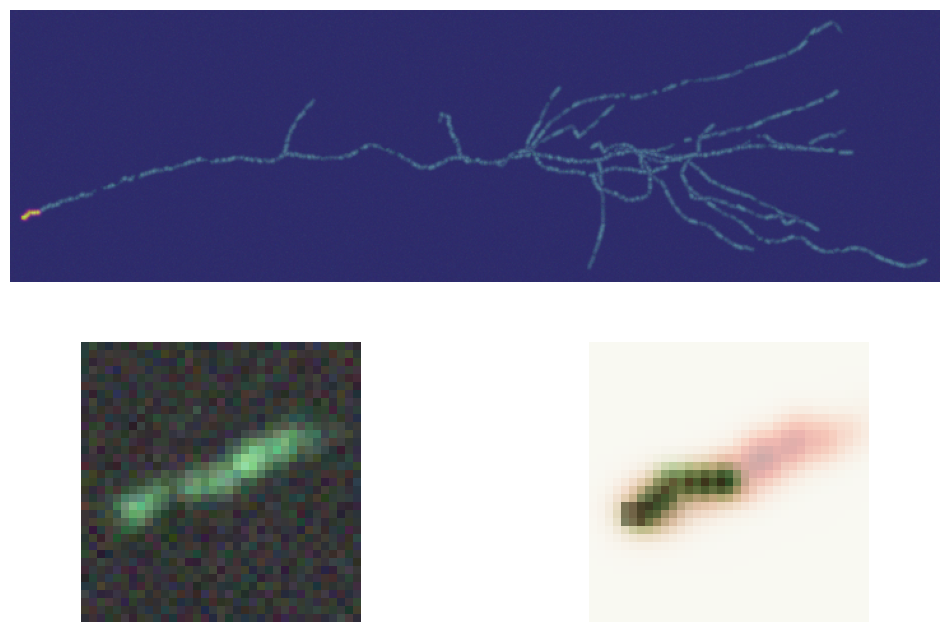

In [5]:
tracking_interface.manual_step(env)

In [8]:
env.img_files[env.img_idx]

'/nafs/dtward/bryson/data/simulated_neurons/neuromorpho_with_artifacts/150304_2_3_d'

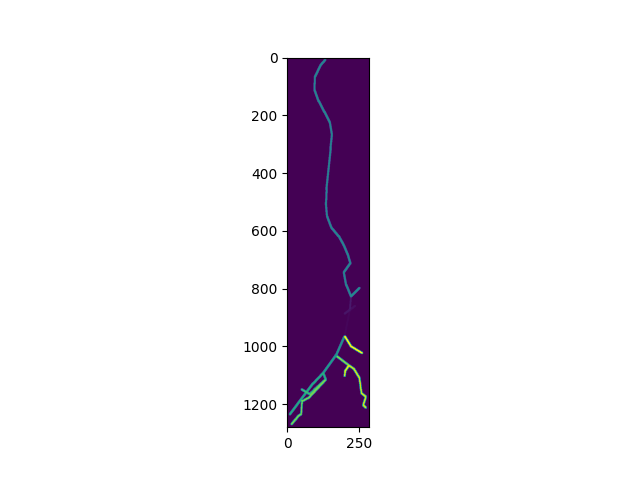

In [6]:
labels = env.section_labels.data[0]

plt.imshow(labels.amax(0))

In [3]:
config = '/home/bgray/neurotrack/configs/train_sac_test.json'
with open(config) as f:
    params = json.load(f)

img_path = params["img_path"]
# outdir = params["outdir"]
outdir = '/home/bgray/neurotrack/notebooks/test_tracking_outputs'
name = params["name"]
step_size = params["step_size"] if "step_size" in params else 1.0
step_width = params["step_width"] if "step_width" in params else 1.0
batch_size = params["batchsize"] if "batchsize" in params else 256
tau = params["tau"] if "tau" in params else 0.005
gamma = params["gamma"] if "gamma" in params else 0.99
lr = params["lr"] if "lr" in params else 0.001
alpha = params["alpha"] if "alpha" in params else 1.0
beta = params["beta"] if "beta" in params else 1e-3
friction = params["friction"] if "friction" in params else 1e-4
n_episodes = params["n_episodes"] if "n_episodes" in params else 100
init_temperature = params["init_temperature"] if "init_temperature" in params else 0.005
target_entropy = params["target_entropy"] if "target_entropy" in params else 0.0
patch_radius = 17

if "classifier_weights" in params:
    classifier_path = params["classifier_weights"]
    classifier_state_dict = torch.load(classifier_path)#, weights_only=True)
    classifier = ResNet3D(ResidualBlock3D, [3, 4, 6, 3], num_classes=1)
    classifier = classifier.to(device=DEVICE, dtype=dtype)
    classifier.load_state_dict(classifier_state_dict)
    classifier.eval()
else:
    classifier = None


in_channels = 4
input_size = 2*patch_radius+1
init_temperature = 0.005
actor = ConvNet(chin=in_channels, chout=4)
actor = actor.to(device=DEVICE,dtype=dtype)

Q1 = ConvNet(chin=in_channels+3,chout=1)
Q1 = Q1.to(device=DEVICE,dtype=dtype)
Q2 = ConvNet(chin=in_channels+3,chout=1)
Q2 = Q2.to(device=DEVICE,dtype=dtype)
Q1_target = ConvNet(chin=7,chout=1)
Q1_target = Q1_target.to(device=DEVICE,dtype=dtype)
Q2_target = ConvNet(chin=7,chout=1)
Q2_target = Q2_target.to(device=DEVICE,dtype=dtype)

if "sac_weights" in params:
    sac_path = params["sac_weights"]
    state_dicts = torch.load(sac_path)#, weights_only=True)
    actor.load_state_dict(state_dicts["policy_state_dict"])
    Q1.load_state_dict(state_dicts["Q1_state_dict"])
    Q2.load_state_dict(state_dicts["Q2_state_dict"])

Q1_target.load_state_dict(Q1.state_dict())
Q2_target.load_state_dict(Q2.state_dict())

log_alpha = torch.log(torch.tensor(init_temperature).to(DEVICE))
log_alpha.requires_grad = True
Q1_optimizer = AdamW(Q1.parameters(), lr=lr)
Q2_optimizer = AdamW(Q2.parameters(), lr=lr)
actor_optimizer = AdamW(actor.parameters(), lr=lr)
log_alpha_optimizer = Adam([log_alpha], lr=lr)

memory = PrioritizedReplayBuffer(100000, obs_shape=(in_channels,input_size,input_size,input_size), action_shape=(3,), alpha=0.8)



In [4]:
env = Environment(img_path,
                radius=patch_radius,
                step_size=step_size,
                step_width=step_width,
                max_len=1000,
                alpha=alpha,
                beta=beta,
                friction=friction,
                classifier=classifier)


In [5]:
import cProfile

with cProfile.Profile() as pr:
    sac.train(env, actor, Q1, Q2, Q1_target, Q2_target, log_alpha,
        actor_optimizer, Q1_optimizer, Q2_optimizer, log_alpha_optimizer,
        memory, target_entropy, batch_size, gamma, tau, outdir, name,
        show_states=False, save_snapshots=False, update_after=256,
        updates_per_step=1, update_every=1, n_episodes=n_episodes, n_trials=1)
    
    # Sort stats by cumulative time
    pr.print_stats(sort='tottime')

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:34<00:00,  8.67s/it]

         765134 function calls (749240 primitive calls) in 34.694 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    14659   21.701    0.001   21.701    0.001 {method 'acquire' of '_thread.lock' objects}
       85    5.485    0.065    8.365    0.098 sac_tracking_env.py:319(step)
      385    1.104    0.003    1.904    0.005 image.py:162(crop)
       85    0.964    0.011    0.966    0.011 buffer.py:152(push)
       81    0.881    0.011    0.881    0.011 {built-in method cat}
      166    0.784    0.005    0.784    0.005 {built-in method ones}
     2628    0.594    0.000    0.594    0.000 {built-in method conv3d}
      304    0.470    0.002    0.470    0.002 {method 'clone' of 'torch._C._TensorBase' objects}
        8    0.469    0.059   24.230    3.029 sac_tracking_env.py:447(reset)
       93    0.281    0.003    0.281    0.003 {built-in method zeros}
        4    0.235    0.059   22.630    5.657 sac_tracking_env.py:215(__l

In [9]:
len(env.finished_paths)

33

In [10]:
print([len(f) for f in env.finished_paths])

[4, 4, 6, 10, 14, 3, 31, 16, 27, 16, 22, 20, 27, 35, 36, 67, 28, 21, 18, 41, 18, 14, 47, 71, 82, 36, 102, 88, 70, 20, 95, 21, 93]
